# Tutorials
https://github.com/NielsRogge/Transformers-Tutorials/blob/master/VisionTransformer/Quick_demo_of_HuggingFace_version_of_Vision_Transformer_inference.ipynb
https://huggingface.co/docs/transformers/en/model_doc/trocr

Vision Text Dual-Encoder: CLIP and Contrastive Learning
https://github.com/huggingface/transformers/blob/main/examples/pytorch/contrastive-image-text/README.md
https://huggingface.co/blog/vision_language_pretraining
https://medium.com/@brianpulfer/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c

Learn OpenCV: TrOCR Finetuning:
https://learnopencv.com/fine-tuning-trocr-training-trocr-to-recognize-curved-text/#aioseo-fine-tuning-trocr-on-curved-text

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import torch
#from transformers import ViTForImageClassification

In [2]:
## Seeding
# Define a set seed to make this process fully reproduceable
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

# Import and the model and processor


In [3]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
#import torch

# VISION TEXT ENCODER DECODER


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f" Using device: {device} : {torch.cuda.get_device_name(device)}")


#processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')

#model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')

#model.save_pretrained("TrOCR")

 Using device: cuda : NVIDIA GeForce RTX 4070 Ti SUPER


In [4]:
# Configs
from dataclasses import dataclass

# Training config
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:         int = 8
    EPOCHS:             int = 15
    LEARNING_RATE:      float = 0.00005

# Dataset
@dataclass(frozen=True)
class DatasetConfig:
    Data_Source:        str = 'dataset/IM2LATEX-100K-HANDWRITTEN'
    Formulas:           str = 'dataset/IM2LATEX-100K-HANDWRITTEN/formulas.lst'
    Images_Dir:         str = 'dataset/IM2LATEX-100K-HANDWRITTEN/images/'
    Max_Target_Length:  int =512

# Model config
@dataclass(frozen=True)
class ModelConfig:
    MODEL_NAME: str = 'microsoft/trocr-small-handwritten' #'microsoft/trocr-small-handwritten'

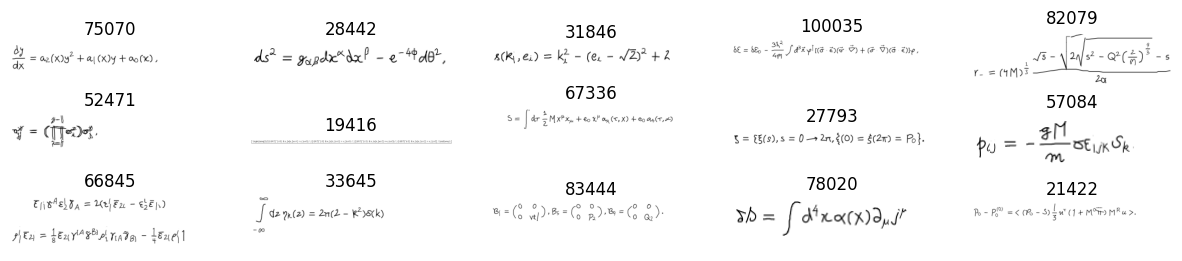

In [5]:
import matplotlib.pyplot as plt
import os

def visualize(dataset_path):
    plt.figure(figsize=(15, 3))
    for i in range(15):
        plt.subplot(3, 5, i+1)
        images = os.listdir(f"{dataset_path}/images")
        image = plt.imread(f"{dataset_path}/images/{images[i]}")
        plt.imshow(image)
        plt.axis('off')
        plt.title(images[i].split('.')[0])
    plt.show()

visualize(DatasetConfig.Data_Source)

In [6]:
# Pandas dataset prep
import pandas as pd

try:
#    with open(list_file, 'r') as f:
#        self.formula_image_pairs = [line.strip().split() for line in f]
    with open(DatasetConfig.Formulas, 'r') as f:
        formulas = f.read().splitlines()
except FileNotFoundError:
    print(f"This file does not exist. {DatasetConfig.Formulas}")
    raise
#formulas
formulas_df = pd.DataFrame(formulas, columns=['formula'])
#formulas_df= formulas_df[formulas_df['formula'].str.len() < DatasetConfig.Max_Target_Length]
#formulas_df

train_df = pd.read_csv(
    os.path.join(DatasetConfig.Data_Source, 'train.lst'), header=None, sep=' '
)
train_df.rename(columns={1: 'image_no', 0: 'formula_no'}, inplace=True)
train_df = train_df.drop(train_df.columns[2], axis=1)
train_df = train_df.merge(formulas_df, left_on='formula_no', right_index=True)
#train_df= train_df= train_df[train_df['formula'].str.len() < DatasetConfig.Max_Target_Length]

test_df = pd.read_csv(
    os.path.join(DatasetConfig.Data_Source, 'test.lst'), header=None, sep=' '
)
test_df.rename(columns={1: 'image_no', 0: 'formula_no'}, inplace=True)
test_df = test_df.drop(test_df.columns[2], axis=1)
test_df = test_df.merge(formulas_df, left_on='formula_no', right_index=True)
#test_df= test_df[test_df['formula'].str.len() < DatasetConfig.Max_Target_Length]

val_df = pd.read_csv(
    os.path.join(DatasetConfig.Data_Source, 'val.lst'), header=None, sep=' '
)
val_df.rename(columns={1: 'image_no', 0: 'formula_no'}, inplace=True)
val_df = val_df.drop(val_df.columns[2], axis=1)
val_df = val_df.merge(formulas_df, left_on='formula_no', right_index=True)
#val_df= val_df[val_df['formula'].str.len() < DatasetConfig.Max_Target_Length]

train_df

,formula_no,image_no,formula
0,36003,37436,"\label{113}dG^{*(5)}={1\over 4}J^{*(4)},"
1,48127,50043,y\propto \left[\cot(\eta/2)\right]^{(1+\sqrt{1...
2,79113,82314,"A\,=\,\left(\begin{array}{ccc}0&{\,\,}&\Theta_..."
3,54980,57179,a G(\phi) \frac{\partial \rho}{\partial t} = -...
4,32638,33934,J\equiv \left.{{\delta S_{\rm{\small int}}}\ov...
...,...,...,...
79547,86079,89587,"F(\bar{y},z) = \sum_{s} \oint\frac{\bar{du}}{2..."
79548,46134,47969,"X_d=\mbox{diag}\left(x_1,x_2,\ldots ,x_n\right..."
79549,73398,76373,\label{limt}\lim _{\tau \rightarrow \infty }\U...
79550,52959,55081,"\begin{array}{l}[H_i,H_j]=0~,\\[1mm][H_i,X_j^\..."


In [7]:
# Image collation and preprocessing function

import torch
import random

def collate_function(batch):
    images = [item['image'] for item in batch]
    formulas = [item['formula'] for item in batch]

    # Get the maximum height and width in the batch
    max_height = max(image.size(1) for image in images)
    max_width = max(image.size(2) for image in images)

    # Pad the images to the maximum height and width in the batch
    processed_images = []
    for image in images:
        height, width = image.size(1), image.size(2)

        ## Scale images to match the same width and height of the largest image in the batch
        # Calculate the new height and width of the padded image
        if (max_height - height)/height  < (max_width - width)/width:
            scaling_factor = max_height / height
        else:
            scaling_factor = max_width / width
        
        # scale the new height and widht
        new_height = int(height * scaling_factor)
        new_width = int(width * scaling_factor)

        resized_image = torch.nn.functional.interpolate(
            image.unsqueeze(0), 
            size = (new_height, new_width), 
            mode='bilinear'
        ).squeeze(0)
        
        ## min-max scaling to normalize all images
        min_val = torch.min(resized_image)
        max_val = torch.max(resized_image)
        # Prevent division by zero
        if max_val > min_val:
            resized_image = (resized_image - min_val) / (max_val - min_val)
        else:
            # If max == min, just set to zeros or a constant value
            resized_image = torch.zeros_like(resized_image)
        
    
        # pad and append 5 images with random displacement within batch maximum image size bounds
        for _ in range(5):
            ## Pad images to match the same width and height
            padded_image = torch.ones(image.size(0), max_height, max_width)
            # calculate offsets
            off_x = int(random.random() * (max_width - new_width)) if max_width > new_width else 0
            off_y = int(random.random() * (max_height - new_height)) if max_height > new_height else 0

            padded_image[:, off_y:(new_height + off_y), off_x:(new_width + off_x)] = resized_image

            # add images into processed images array
            processed_images.append(padded_image)
    
    # Stack the resized images
    resized_images = torch.stack(processed_images)

    return {'image': resized_images, 'formula': formulas}

In [8]:
# Assemble dataset
import os
from skimage import io, transform
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision import transforms


# ==== ++++ ==== ++++ ==== ++++ ==== ++++ ==== ++++ ==== ++++ ==== ++++ ==== ++++ 
  # PATHS AND PRESETS
   
#images_folder = "dataset/IM2LATEX-100K-HANDWRITTEN/images"
#train_list = "dataset/IM2LATEX-100K-HANDWRITTEN/train.lst"
#test_list = "dataset/IM2LATEX-100K-HANDWRITTEN/test.lst"
#val_list = "dataset/IM2LATEX-100K-HANDWRITTEN/val.lst"
#formulas_file = "dataset/IM2LATEX-100K-HANDWRITTEN/formulas.lst"
#batch_size = 3

#output_dir = "output/"

# ==== ++++ ==== ++++ ==== ++++ ==== ++++ ==== ++++ ==== ++++ ==== ++++ ==== ++++ 

class IM2LATEXDataset(Dataset):
    def __init__(self, root_dir, df, processor, formulas_file, max_target_length):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length
        #self.transform = transforms.Compose([
        #    transforms.ColorJitter(brightness=.5, hue=.3),
        #    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        #])
        self.transform = None

        try:
        #    with open(list_file, 'r') as f:
        #        self.formula_image_pairs = [line.strip().split() for line in f]
            with open(formulas_file, 'r') as f:
                self.formulas = f.read().splitlines()
        except FileNotFoundError:
            print(f"This file does not exist. {formulas_file}")
            raise
        #print(self.formulas[11869], self.formula_image_pairs[70975])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        try:
            # get formula_image pair
            image_no = self.df['image_no'][idx]
            formula = self.df['formula'][idx]

            # create image path from image name
            img_path = os.path.join(DatasetConfig.Images_Dir, str(image_no) + '.png')
            img_path

            #attempt to open images and convert to greyscale
            try:
                image = Image.open(img_path)#.convert('L')
            except FileNotFoundError:
                print(f"Image not found: {img_path}")
                raise

            # transform image if transform exists
            if self.transform:
                image = self.transform(image)

            # return pixel values
            pixel_values = self.processor(image, return_tensors='pt').pixel_values

            # process labels
            labels=self.processor.tokenizer(
                formula,
                padding='max_length',
                max_length=self.max_target_length,
                truncation=True
            ).input_ids
            # use '-100' as a padding token
            labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

            # make encoding
            encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
            return encoding
            #return {"image": image, "formula": formula}
        
        except Exception as e:
            # catch imageloading exceptions
            print(f"Error in __getitem__ at index {idx}: {e}")
            # print(f"Image-formula pair: {self.formula_image_pairs[idx]}")
            raise

#def load_im2latex_dataset(images_folder, train_list, test_list, val_list, formulas_file, batch_size=batch_size, transform=None):
#    
#    # create transforms for image
#    if transform is None:
#        transform = transforms.Compose([
#            transforms.ToTensor(),
#            transforms.Normalize(mean=[0.485], std=[0.229]),
#            #transforms.Resize((224, 224))
#        ])
#    
#    # create train, test, validation datasets
#    train_dataset = IM2LATEXDataset(images_folder, train_list, formulas_file, transform)
#    test_dataset = IM2LATEXDataset(images_folder, test_list, formulas_file, transform)
#    val_dataset = IM2LATEXDataset(images_folder, val_list, formulas_file, transform)
#    
#    # load datasets
#    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_function)
#    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_function)
#    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_function)
#    
#    return train_loader, test_loader, val_loader
#
#
## run dataset loader
#train_loader, test_loader, val_loader = load_im2latex_dataset(images_folder, train_list, test_list, val_list, formulas_file, batch_size=batch_size)

In [9]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, Seq2SeqTrainer, Seq2SeqTrainingArguments, default_data_collator

processor = TrOCRProcessor.from_pretrained(ModelConfig.MODEL_NAME)
train_dataset = IM2LATEXDataset(
    DatasetConfig.Data_Source, 
    train_df, 
    processor=processor, 
    formulas_file=DatasetConfig.Formulas,
    max_target_length=DatasetConfig.Max_Target_Length
)

test_dataset = IM2LATEXDataset(
    DatasetConfig.Data_Source, 
    test_df, 
    processor=processor, 
    formulas_file=DatasetConfig.Formulas,
    max_target_length=DatasetConfig.Max_Target_Length
)

val_dataset = IM2LATEXDataset(
    DatasetConfig.Data_Source, 
    val_df, 
    processor=processor, 
    formulas_file=DatasetConfig.Formulas,
    max_target_length=DatasetConfig.Max_Target_Length
)

#data = train_dataset.__getitem__(1)
#plt.imshow(data["pixel_values"].reshape(384,384,3))
#print(data['labels'])


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VisionEncoderDecoderModel.from_pretrained(ModelConfig.MODEL_NAME)
model.to(device)
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad
)
print(f"{total_trainable_params:,} training parameters.")

	
# Set special tokens used for creating the decoder_input_ids from the labels.
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# Set Correct vocab size.
model.config.vocab_size = model.config.decoder.vocab_size
model.config.eos_token_id = processor.tokenizer.sep_token_id
 
 
model.config.max_length = DatasetConfig.Max_Target_Length/4
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 8

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(in_features=384, out_features=1536, bias=True)
        

In [ ]:
# pretraining setup

# optimizer
from torch.optim import AdamW
import evaluate

optimizer = AdamW(
    model.parameters(),
    lr=TrainingConfig.LEARNING_RATE,
    weight_decay=0.0005
)

# Character error
cer_metric = evaluate.load('cer')

def compute_cer(pred):
    label_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    eval_strategy='epoch',
    per_device_train_batch_size=TrainingConfig.BATCH_SIZE,
    per_device_eval_batch_size=TrainingConfig.BATCH_SIZE,
    fp16=True,
    output_dir='output/',
    logging_dir='logs/',
    logging_strategy='epoch',
    save_total_limit=5,
    report_to='tensorboard',
    num_train_epochs=TrainingConfig.EPOCHS
)

In [12]:

# Training
trainer = Seq2SeqTrainer(
    model = model,
    processing_class = processor.image_processor,
    args = training_args,
    compute_metrics = compute_cer,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    data_collator = default_data_collator
)

res =trainer.train()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss,Cer
1,2.728400,1.829166,0.850896
2,1.559600,1.327618,0.705999
3,1.265000,1.159623,0.752043
4,1.106100,1.063317,1.026446
5,1.003600,0.987099,0.781401
6,0.927100,0.950142,0.748777
7,0.868300,0.914393,0.885045
8,0.819100,0.887314,0.799606
9,0.776500,0.862781,0.808399
10,0.739000,0.845539,0.747804


/home/kit/Documents/handwriting2Markdown/.venv/lib/python3.12/site-packages/transformers/modeling_utils.py:3465: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


  0%|          | 0/99552 [00:00<?, ?it/s]

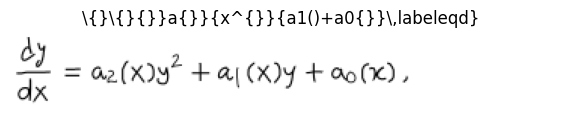

  0%|          | 1/99552 [00:00<3:21:13,  8.25it/s]

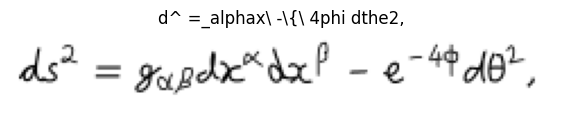

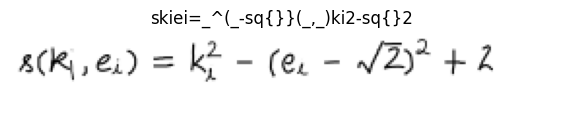

  0%|          | 3/99552 [00:00<2:53:55,  9.54it/s]

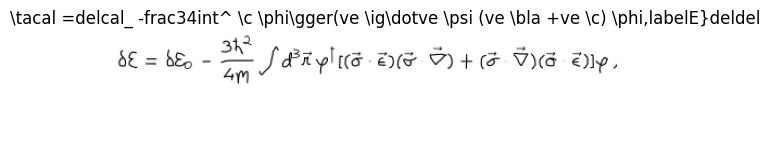

  0%|          | 4/99552 [00:00<3:22:54,  8.18it/s]

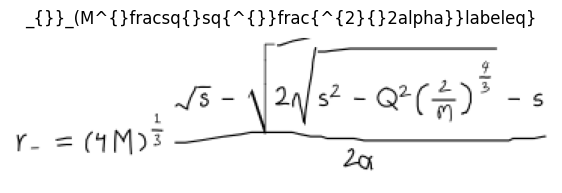

  0%|          | 5/99552 [00:00<3:12:04,  8.64it/s]

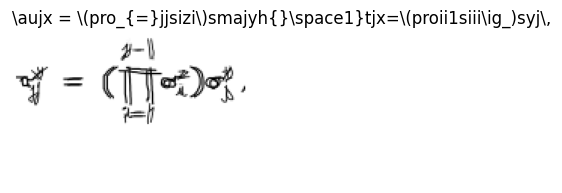

  0%|          | 6/99552 [00:00<3:42:19,  7.46it/s]

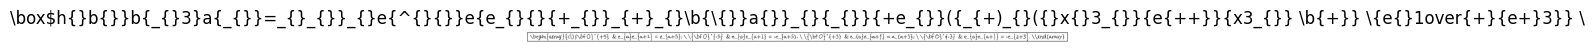

  0%|          | 7/99552 [00:01<5:51:05,  4.73it/s]

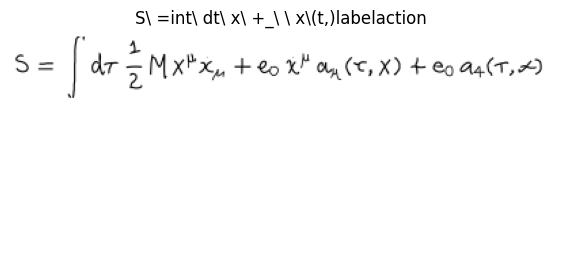

  0%|          | 8/99552 [00:01<4:54:15,  5.64it/s]

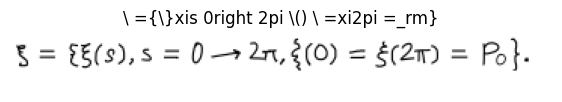

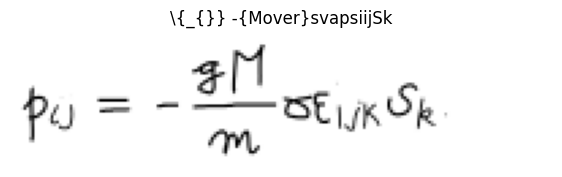

  0%|          | 10/99552 [00:01<3:51:38,  7.16it/s]


In [16]:
import glob
import tqdm

model = VisionEncoderDecoderModel.from_pretrained('output/checkpoint-'+str(res.global_step)).to(device)

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device('cpu')

model.to(device)

def eval_new_data(
    data_path=os.path.join(DatasetConfig.Images_Dir, '*'),
    num_samples=20
):
    image_paths = glob.glob(data_path)
    for i, image_path in tqdm.tqdm(enumerate(image_paths), total=len(image_paths)):
        if i == num_samples:
            break
        image = Image.open(image_path).convert("RGB")
        
        pixel_values = processor(image, return_tensors='pt').pixel_values.to(device)
        generated_ids = model.generate(pixel_values)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

        plt.figure(figsize=(7, 4))
        plt.imshow(image)
        plt.title(generated_text)
        plt.axis('off')
        plt.show()
 
eval_new_data(
    data_path=os.path.join(DatasetConfig.Images_Dir, '*'),
    num_samples=10
)
